# **Problem statement**

Predict the review ratings of products on Amazon

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import xgboost as xgb
from google.colab import files

# **Stop words**

In Natural Language Processing (NLP), useless words in the data/text are referred to as stop words. We download a list of those words from the NLTK corpus so that we can remove them from our text during preprocessing.

In [ ]:
# Download stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **WordNet**

Wordnet is an NLTK corpus reader, a lexical database for English. It can be used to find the meaning of words, synonym or antonym. One can define it as a semantically oriented dictionary of English.

In [ ]:
# Download WordNet (lexical database for English language)
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Operations on train dataset**

* Statistical analysis
* Basic EDA
* Dealing with NaN values
* Text pre-processing
* Word cloud analysis for post-processing

In [ ]:
# Read the training data
pr_data = pd.read_csv("...") [Redacted]
pr_data.head()

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers,average_review_rating
0,7f890f73298badd692c39c3801ef1d28,Batman - Role Play - Cowl and Batarang,Mattel,£14.99,NaN,4,1.0,Figures & Playsets > Science Fiction & Fantasy,http://www.amazon.co.uk/Rubies-Costume-Co-Flas...,"When kids aspire to be like Batman, it's easy ...",Technical Details Item Weight113 g Product Dim...,"When kids aspire to be like Batman, it's easy ...",http://www.amazon.co.uk/Rubies-Costume-Co-Flas...,NaN,Item was broken // 3.0 // 2 April 2014 // By\n...,"{""seller""=>{""Seller_name_1""=>""a1 Toys"", ""Selle...",4.5
1,83e55a2edb6c13dfc1c46d1577321b2e,Doctor Who 12-inch 50th Anniversary Collector ...,Dr Who,NaN,3 new,73,NaN,Figures & Playsets > Science Fiction & Fantasy,http://www.amazon.co.uk/Doctor-Who-Classic-Dal...,Product Description This ultimate Doctor Who c...,Technical Details Item Weight1.4 Kg Product Di...,Product Description This ultimate Doctor Who c...,http://www.amazon.co.uk/Dr-Who-Dalek-Projectio...,NaN,A wonderful collectors piece // 5.0 // 31 Aug....,NaN,4.6
2,4bfaaf6558582a0f337ad59fcd51fcf7,Melissa & Doug Sticker Collection - Pink,Melissa & Doug,£4.76,15 new,47,1.0,Arts & Crafts > Paper & Stickers,http://www.amazon.co.uk/Melissa-Doug-Sticker-C...,"Product Description Cute couture, adorable ani...",Technical Details Item Weight299 g Product Dim...,"Product Description Cute couture, adorable ani...",http://www.amazon.co.uk/Melissa-Doug-Habitats-...,NaN,Great sticker collection // 5.0 // 19 Jun. 201...,NaN,4.7
3,4e6702cb7fe9278f16dedc39a8808c72,"Rock and Roll Cards, 30 Team",ClubKing Ltd,£4.49,2 new,2,1.0,Hobbies > Trading Cards & Accessories > Packs ...,http://www.amazon.co.uk/ClubKing-Ltd-Football-...,"1 Pack of 25 Football Cards, 30 rockstars on e...",Technical Details Item Weight100 g Product Dim...,"1 Pack of 25 Football Cards, 30 rockstars on e...",http://www.amazon.co.uk/ClubKing-Ltd-Football-...,how many cards in a pack it dosn't say..?? // ...,Rock and roll cards // 5.0 // 28 July 2013 // ...,"{""seller""=>[{""Seller_name_1""=>""ClubKing Ltd"", ...",5.0
4,f505611d18b0ae98258896ae1b0f14c8,Crayola 16 Pipsqueak Glitter Glues,Crayola,£5.99,9 new,10,1.0,Characters & Brands > Crayola,http://www.amazon.co.uk/Crayola-3-3542-9-Glitt...,Product Description 16 Pipsqueak washable glit...,Technical Details Item Weight186 g Product Dim...,Product Description 16 Pipsqueak washable glit...,http://www.amazon.co.uk/Crayola-3-3542-9-Glitt...,NaN,Little fingers big imagination // 5.0 // 4 Mar...,"{""seller""=>[{""Seller_name_1""=>""BIC WAREHOUSE"",...",4.2


In [ ]:
# Use columns relevant to our case
df = pr_data[['customer_reviews', 'average_review_rating']]
df.head()

,customer_reviews,average_review_rating
0,Item was broken // 3.0 // 2 April 2014 // By\n...,4.5
1,A wonderful collectors piece // 5.0 // 31 Aug....,4.6
2,Great sticker collection // 5.0 // 19 Jun. 201...,4.7
3,Rock and roll cards // 5.0 // 28 July 2013 // ...,5.0
4,Little fingers big imagination // 5.0 // 4 Mar...,4.2


In [ ]:
# Check the rating distribution
df['average_review_rating'].value_counts()

5.0    3870
4.0     999
4.5     538
4.8     425
4.7     389
4.3     299
4.6     282
4.4     234
4.9     173
4.2     159
4.1     106
3.9       3
3.3       2
3.6       2
3.5       2
3.7       2
3.0       1
Name: average_review_rating, dtype: int64

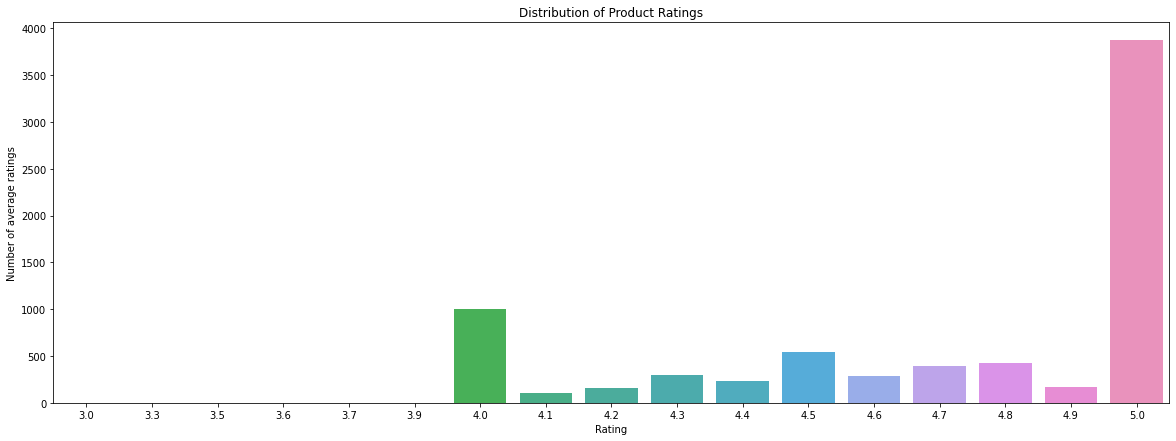

In [ ]:
# Visualize the rating distribution
f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(x=df['average_review_rating'])
ax.set(title="Distribution of Product Ratings", xlabel="Rating", ylabel="Number of average ratings")
plt.show()

In [ ]:
# Check the statistical summary for the ratings
df.describe()

,average_review_rating
count,7486.000000
mean,4.707561
std,0.371987
min,3.000000
25%,4.500000
50%,5.000000
75%,5.000000
max,5.000000


In [ ]:
# Print reviews for a product
print (df['customer_reviews'][1])

A wonderful collectors piece // 5.0 // 31 Aug. 2013 // By
    
    SteveINtheUKok
  
TOP 1000 REVIEWER on 31 Aug. 2013 // This is more a collectors item, than a toy.It arrives in a fairly standard Doctor Who box, albeit quite large.Its packed very well indeed you'll need a small screwdriver and some patience to remove it from its protective box. I prefer this way than rattling around getting broken.You'll also need to feed it 4xAA batteries as they are not included.There is a little assembly required, putting the eye stalk on wasn't the easiest task, don't force it! Once you realise its keyed, think of the keystone of a bridge or window and turn it sideways, it has a long edge on the right, a shorter edge on the left and then draw two lines top and bottom at an angle so they meet up, once you notice that putting the stalk on is much easier, if it fails to light, like mine did, gently push in the springy contacts under the stalk a few times to loosen them after transit and it should lig

In [ ]:
# Check for NaN values
df.isna().any()

customer_reviews          True
average_review_rating    False
dtype: bool

In [ ]:
# Check for total NaN values present in the columns
df.isna().sum()

customer_reviews         3
average_review_rating    0
dtype: int64

In [ ]:
# Drop the NaN values and adjust the indexing
df = df.dropna().reset_index(drop=True)

**Preprocessing of customer reviews in the train set**

In [ ]:
# Text preprocessing
def preprocessing(user_reviews):
  review = BeautifulSoup(user_reviews).get_text() # Remove HTML tags
  review = re.sub("[^a-zA-Z]", " ", review) # Remove special characters
  review = review.lower().split() # Convert to lowercase and split each word

  stop_w = set(stopwords.words("english")) # Use a set instead of list for faster searching
  review = [w for w in review if not w in stop_w] # Remove stop words
  review = [WordNetLemmatizer().lemmatize(w) for w in review] # Lemmatization

  return (" ".join(review)) # Return the words after joining each word separated by space

In [ ]:
# Clean all reviews in the train set
clean_reviews = []

for i in range(0, df['customer_reviews'].size):
  clean_reviews.append(preprocessing(df['customer_reviews'][i]))

In [ ]:
# Check reviews of a sample product after preprocessing
clean_reviews[1]

'wonderful collector piece aug steveintheukok top reviewer aug collector item toy arrives fairly standard doctor box albeit quite large packed well indeed need small screwdriver patience remove protective box prefer way rattling around getting broken also need feed xaa battery included little assembly required putting eye stalk easiest task force realise keyed think keystone bridge window turn sideways long edge right shorter edge left draw two line top bottom angle meet notice putting stalk much easier fails light like mine gently push springy contact stalk time loosen transit light fine left pop plunger ray gun plunger left ray gun right ray gun longer end go hole shorter actually quite easy put together saved bottom retaining plastic cup screw put back let sit flat shelf raise wheel touch tell happens daleks black skirt ooh err keep rolling explore universe know theyre like lol recorded dalek phrase high quality head light call flash white speaks turned blue led eye stalk glow min t

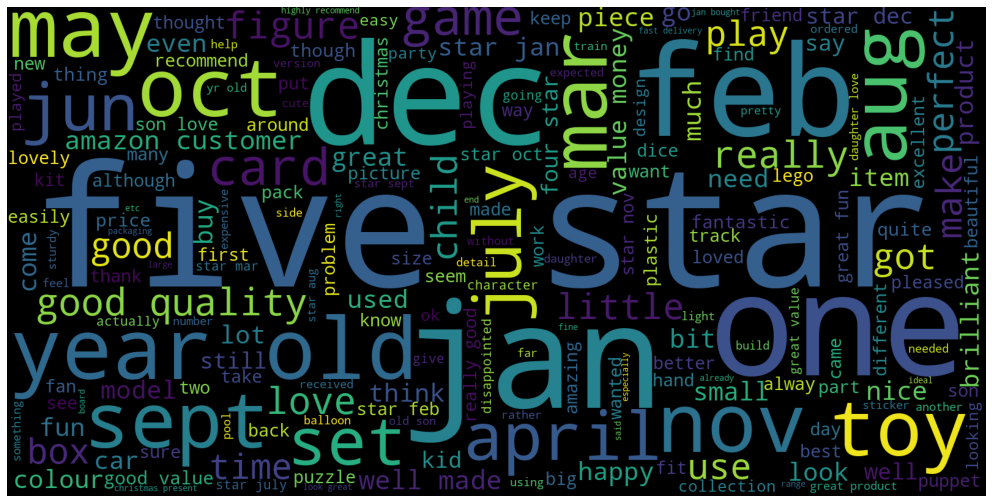

In [ ]:
# Display word cloud from review data
unique_str=(" ").join(clean_reviews)
wordcloud = WordCloud(width=1600,height=800).generate(unique_str)
plt.figure(figsize=(18,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# **Operations on test dataset**

* Dealing with NaN values
* Text pre-processing

In [ ]:
# Read test data
test_data = pd.read_csv('...') [Redacted]
test_data.head()

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
0,90093bd02c6d5ce6d6c8f2e2af411fc1,Dolls House Miniature Cats x2,Heidi Ott,£12.00,NaN,1,1.0,Dolls & Accessories > Dolls' House Dolls & Acc...,NaN,A pair of dolls house miniature cats. This 1/1...,Technical Details Item Weight5 g Product Dimen...,A pair of dolls house miniature cats. This 1/1...,NaN,NaN,Dolls house miniatures // 5.0 // 9 Jan. 2013 /...,"{""seller""=>{""Seller_name_1""=>""1 12 Dollshouses..."
1,8dec13104fd4d1ad3ad5d9ff2af9ca0b,Disney Princess T7561 Tangled Rapunzel's Gondo...,Disney Princess,NaN,5 new,15,4.0,Characters & Brands > Disney > Toys,http://www.amazon.co.uk/Disney-Princess-Y0942-...,Product Description Relive the romantic moment...,Technical Details Item Weight907 g Product Dim...,Product Description Relive the romantic moment...,http://www.amazon.co.uk/Disney-Princess-Y0942-...,NaN,Tangled // 4.0 // 16 May 2011 // By\n \n ...,"{""seller""=>[{""Seller_name_1""=>""Anita Mall"", ""S..."
2,0fcde78856668c1563f54650b17620e7,My Pirate Party Music CD,Unknown,£4.99,1 used,6,1.0,Figures & Playsets > Pirates,http://www.amazon.co.uk/Pirate-Pencils-Childre...,Set the atmosphere for your Pirate themed part...,Technical Details Manufacturer recommended age...,Set the atmosphere for your Pirate themed part...,http://www.amazon.co.uk/Jake-And-The-Neverland...,NaN,Okay but that's all // 1.0 // 11 July 2011 // ...,"{""seller""=>{""Seller_name_1""=>""BuzzBase"", ""Sell..."
3,69a9becbd60381a4eb7cdafe30761ee4,1ST BIRTHDAY BANNER GIRL (BGC HOLOGRAPHIC) 9FT...,Every-occasion-party-supplies,£1.49,5 new,22,1.0,"Party Supplies > Banners, Stickers & Confetti ...",http://www.amazon.co.uk/1ST-BIRTHDAY-GIRL-PINK...,12ft long,Technical Details Manufacturer recommended age...,12ft long,http://www.amazon.co.uk/12ft-Foil-Ladybird-Bir...,NaN,Good quality but take down carefully as the fo...,NaN
4,18bc8b988f43f352b946a253642e1c6e,Beavis and Butt-Head Great Cornholio Bobble Head,Beavis And Butt-Head,£84.43,NaN,1,1.0,Hobbies > Collectible Figures & Memorabilia > ...,NaN,From the Beavis and Butt-Head TV series comes ...,Technical Details Item Weight159 g Product Dim...,From the Beavis and Butt-Head TV series comes ...,NaN,NaN,hilarious // 5.0 // 11 Dec. 2013 // By\n \n...,"{""seller""=>{""Seller_name_1""=>""M and N Media US..."


In [ ]:
# Use column relevant to our case
dt = test_data[['customer_reviews']]
dt.head()

,customer_reviews
0,Dolls house miniatures // 5.0 // 9 Jan. 2013 /...
1,Tangled // 4.0 // 16 May 2011 // By\n \n ...
2,Okay but that's all // 1.0 // 11 July 2011 // ...
3,Good quality but take down carefully as the fo...
4,hilarious // 5.0 // 11 Dec. 2013 // By\n \n...


In [ ]:
# Check for any NaN value
dt.isna().any()

customer_reviews    False
dtype: bool

In [ ]:
# Clean all reviews in test set
test_reviews = []

for i in range(0, dt['customer_reviews'].size):
  test_reviews.append(preprocessing(dt['customer_reviews'][i]))

In [ ]:
# Assign reviews and labels to conventional variables (X_train, y_train, X_test)
X_train = np.stack(clean_reviews)
y_train = df['average_review_rating']
X_test = np.stack(test_reviews)

**Term Frequency Inverse Document Frequency (TF-IDF)**

This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.

In [ ]:
# Use TF-IDF to vectorize
tfidf_vec = TfidfVectorizer(ngram_range=(1, 4)) # Range of tokens into consideration
tfidf_train = tfidf_vec.fit_transform(X_train)
tfidf_test = tfidf_vec.transform(X_test)

# **Model fitting**

Now, we fit the following models to the given data:

1. K-Nearest Neighbor (KNN) Regressor
2. Support Vector Regressor (SVR)
3. XGBoost Regressor


**Evaluation criteria:** Mean cross-validation scores over 5 folds



In [ ]:
# Define the model
knn = KNeighborsRegressor()
# Create a dictionary of all values to be tested for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 30)}
# Use grid search to test all values for n_neighbors
model1 = GridSearchCV(knn, param_grid, cv=5)

In [ ]:
# Fit KNN model to data
model1.fit(tfidf_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# Check top performing n_neighbors value
model1.best_params_

{'n_neighbors': 24}

In [ ]:
# Check cross validation scores and their mean value
cv1 = cross_val_score(model1, tfidf_train, y_train, cv=5)
print(cv1)
print('Mean cross validation scores: {}'.format(np.mean(cv1)))

[0.19063132 0.22484562 0.21615654 0.2258523  0.22842064]
Mean cross validation scores: 0.2171812853463455


In [ ]:
# Fit SVR model to data
model2 = svm.SVR()
model2.fit(tfidf_train, y_train)

# Check cross validation scores and their mean value
cv2 = cross_val_score(model2, tfidf_train, y_train, cv=5)
print(cv2)
print('Mean cross validation scores: {}'.format(np.mean(cv2)))

[0.25517197 0.25210782 0.26961728 0.26613927 0.2733417 ]
Mean cross validation scores: 0.26327560619012014


In [ ]:
# Fit XGB model to data
model3 = xgb.XGBRegressor()
model3.fit(tfidf_train, y_train)

[12:37:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
# Check cross validation scores and their mean value
cv3 = cross_val_score(model3, tfidf_train, y_train, cv=5)
print(cv3)
print('Mean cross validation scores: {}'.format(np.mean(cv3)))

[12:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:42:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:49:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.39755102 0.40407835 0.3939659  0.37976105 0.41375425]
Mean cross validation scores: 0.39782211174554655


# **Predicting the ratings and generating submission file**

In [ ]:
# Make predictions on test set
target = model3.predict(tfidf_test)

In [ ]:
# Store the predictions in the required format
result = pd.DataFrame(target)
result.index = test_data[['customer_reviews']].index
result.columns = ["prediction"]

# Download the csv file
result.to_csv('prediction_results.csv')         
files.download('prediction_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Future improvements**

* Deal with class imbalance: Bootstrapping won't work in this case due to low number of reviews in the under-represented classes
* Find optimal hyperparameters for SVR/XGBoost: Not enough resources for fast computation